In [5]:
from event import *
from mm1 import *
from scheduler import *
from simulator import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
# SETTINGS
SEED = 42
warmup = False
warmup_events = 1000
lambda_ = 1 #arrival_rate
mu = 2 #service_rate

os.makedirs("results", exist_ok=True) if not os.path.exists("results") else None
csv_name = f"mm1_{lambda_}_{mu}_warmup.csv" if warmup else f"mm1_{lambda_}_{mu}_nowarmup.csv"
path_to_csv=os.getcwd() + f"/results/{csv_name}.csv"

#delete the file if it exists
if os.path.exists(path_to_csv):
    os.remove(path_to_csv)

# Setup and run the simulator

In [7]:

# Termination policy: stop when the simulation time reaches 100,000 time units
policy = (TerminationPolicy()
          .add(lambda srv, sched, narr, ndep, abs_t: abs_t >= int(1e3)).all())

# Run the simulation
print(f"Running simulation with arrival rate: {lambda_}, service rate: {mu}, warmup: {warmup}")
sim = Simulator(arrival_rate=lambda_, service_rate=mu, seed=SEED, path_to_csv=path_to_csv)
sim.run(termination_condition=policy, warmup=warmup, warmup_events=warmup_events)
sim.report()

Running simulation with arrival rate: 1, service rate: 2, warmup: False
Skipping warmup phase.
Running simulation...
Arrivals: 1001
Departures: 1000
Final queue length: 0
Server busy: True
Total Arrivals: 1001.000
Total Services: 1000.000


# Plots of Utilization and packets in the system

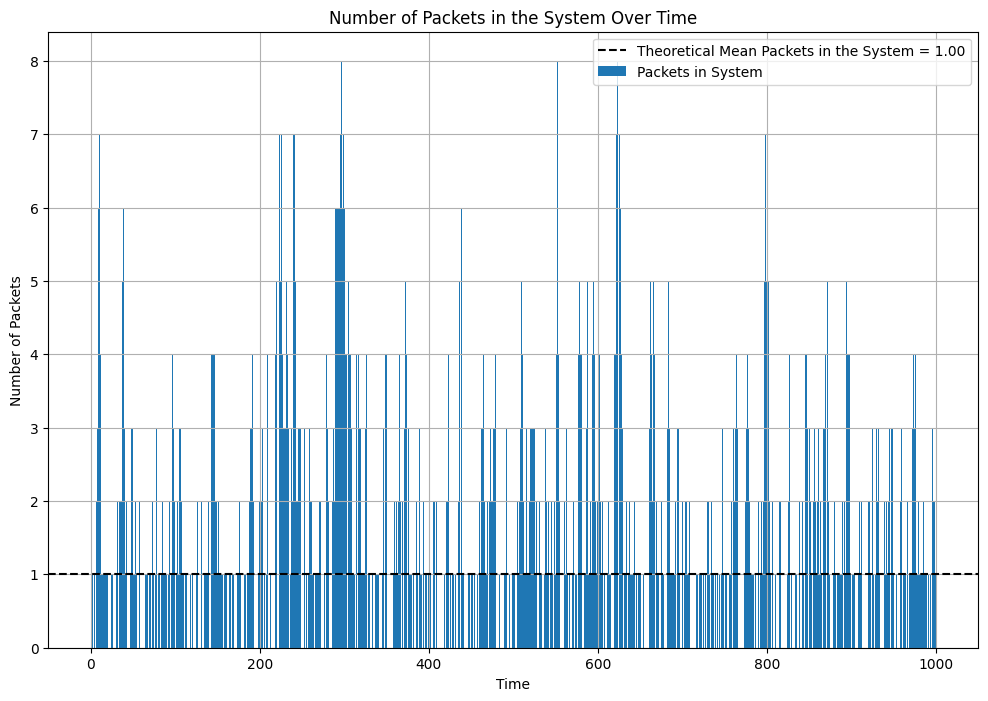

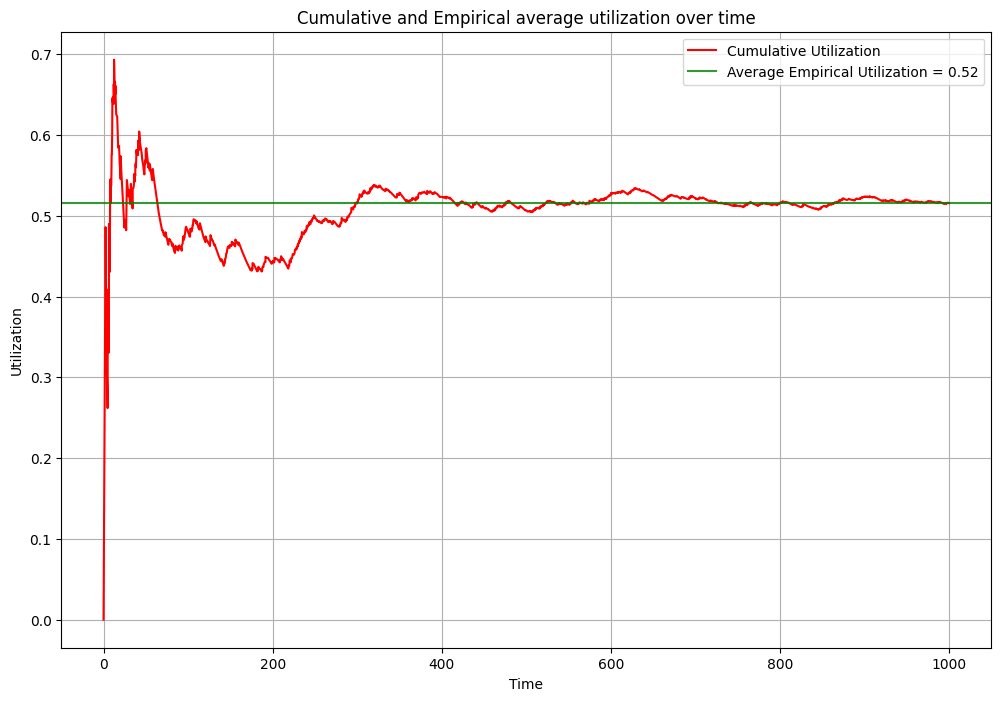

In [8]:
# Load the simulation results from the CSV file
data = pd.read_csv(path_to_csv)
# compute total packets in the system (queue + 1 if busy, else queue)
data['total_current_packets'] = data['queue_length'] + data['server_busy'].astype(int)

ro = lambda_ / mu
# Theoretical average number of packets in the system (stationary regime)
t_packet_mean = ro / (1 - ro) if ro < 1 else np.inf # if arrival rate >= service rate, the system is unstable (it saturates)

#compute the average utilization
data['delta_t'] = data['time'].shift(-1) - data['time']
data['delta_t'] = data['delta_t'].fillna(0.0) # put to zero last value


data['cumulative_busy_time'] = (data['server_busy'] * data['delta_t']).cumsum()
data['elapsed_time'] = data['time'] - data['time'].iloc[0]

data['cumulative_utilization'] = data['cumulative_busy_time'] / data['elapsed_time']
data['cumulative_utilization'] = data['cumulative_utilization'].fillna(0.0) ##fill the Nan in first row

emp_util_mean =data['cumulative_utilization'].iloc[-1]

# Plot the number of packets in the system over time
plt.figure(figsize=(12, 8))
plt.bar(data['time'], data['total_current_packets'], label='Packets in System')
plt.axhline(y=t_packet_mean, color='black', linestyle='--', label=f'Theoretical Mean Packets in the System = {t_packet_mean:.2f}')
plt.xlabel('Time')
plt.ylabel('Number of Packets')
plt.title('Number of Packets in the System Over Time')
plt.legend()
plt.grid()

plt.figure(figsize=(12, 8))
plt.plot(data['time'], data['cumulative_utilization'], label='Cumulative Utilization', color='red')
plt.axhline(emp_util_mean, color='green', label=f'Average Empirical Utilization = {emp_util_mean:.2f}', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.title('Cumulative and Empirical average utilization over time') 
plt.legend()
plt.grid()
plt.show()
